In [1]:
# | default_exp repcrp
%load_ext autoreload
%autoreload 2

## Extension: Repetition-Neighbor Lag-CRP
The lag-CRP measures the probability of recalling an item at a particular lag **given the current recall position**, conditional on items that remain available for recall. Here we follow up on our previous repetition-robust implementation of the Lag-CRP analysis, as well as our Repetition Lag-CRP analysis that separately tracks transitions from repeated items to their neighbors, with a new implementation that allows us to calculate the **Repetition-Neighbor Lag-CRP**.
In this analysis, we calculate transition probabilities from neighbors of the second presentation of repeated items to neighbors of the first presentation of the same repeated items. This allows us to investigate how item repetition affects the contextual features associated with neighboring items in a study list as indicated in free recall.

For repeated items studied at positions $i$ and $j$ with spacing of at least 4 study positions, in this version of the analysis:

1. We only tabualte lag-transitions from recalls of items studied at position $j+1$ (though we still have to track available and actual transitions across trials to accomplish this).
2. We tabulate lags according to the study position of the first presentation of the repeated item, so that we can calculate associations with neighbors of position $i$.

The interesting about this analysis is that the only thing items at positions $j+1$ and neighboring $i$ have in common is that they are both neighbors of the repeated item. The items aren't themselves related to one another, and they aren't studied near one another either. 

## Approach

Our approach extends the repetition-robust implementation of the Lag-CRP analysis by adding a new `NeighborCRPTabulation` class that extends our existing `crp.Tabulation` class, which is used to tabulate the available and actual transitions for the Lag-CRP analysis. The `NeighborCRPTabulation` class is designed to 1) exclusively tabulate transitions from neighbors of the second presentations of repeated items, and 2) recenter lag tabulation on the first presentation of repeated items. This allows us to analyze whether repeating an item associates its neighbors from its second presentation with its neighbors from its first presentation.

To exclusively focus on transitions from second-presentation-repeater-neighbors, we add a `NeighborCRPTabulation.should_tabulate` method that `tabulate` uses to determine based on the previous recalled item whether to tabulate the current recalled item or just update the available transitions (and the previous recalled item) to reflect the current recalled item.

A new `min_lag` parameter is added across the implementation to allow the user to specify a minimum amount of serial lag between first and second presentations of repeated items as a filter for inclusion in the analysis.

In [2]:
# | exports
from typing import Optional, Sequence

from jax import jit, lax, vmap
from jax import numpy as jnp
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes
from simple_pytree import Pytree

from jaxcmr.experimental.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.experimental.repetition import all_study_positions
from jaxcmr.helpers import apply_by_subject
from jaxcmr.typing import Array, Bool, Float, Int_, Integer

In [ ]:
# | exports


def set_false_at_index(vec: Bool[Array, " positions"], i: Int_):
    return lax.cond(i, lambda: (vec.at[i - 1].set(False), None), lambda: (vec, None))


class NeighborCRPTabulation(Pytree):
    "A tabulation of transitions between items during recall of a study list."

    def __init__(
        self,
        true_presentation: Integer[Array, " study_events"],
        mixed_presentation: Integer[Array, " study_events"],
        first_recall: Int_,
        min_lag: int = 4,
        size: int = 2,
    ):
        self.size = size
        self.list_length = mixed_presentation.size
        self.lag_range = self.list_length - 1
        self.all_positions = jnp.arange(1, self.list_length + 1, dtype=int)
        self.base_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.true_item_study_positions = lax.map(
            lambda i: all_study_positions(i, true_presentation, size),
            self.all_positions,
        )
        self.mixed_item_study_positions = lax.map(
            lambda i: all_study_positions(i, mixed_presentation, size),
            self.all_positions,
        )

        # Get first and second study positions
        first_positions = self.mixed_item_study_positions[:, 0]
        second_positions = self.mixed_item_study_positions[:, 1]
        spaced_repeaters = (second_positions - first_positions) > min_lag

        # identify the i for each j+1
        # self.jplus1_to_first = (
        #     jnp.zeros(self.list_length, dtype=int)
        #     .at[second_positions + 1]
        #     .set(jnp.where(spaced_repeaters, first_positions, 0))
        # )
        # self.jplus2_to_first = (
        #     jnp.zeros(self.list_length, dtype=int)
        #     .at[second_positions + 2]
        #     .set(jnp.where(spaced_repeaters, first_positions, 0))
        # )
        mapped = jnp.where(spaced_repeaters, first_positions, 0)
        self.jplus12_to_first = (
            jnp.zeros(self.list_length, dtype=int)
            .at[second_positions + 1]
            .set(mapped)
            .at[second_positions + 2]
            .set(mapped)
        )

        self.actual_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.avail_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)

        self.previous_positions = self.true_item_study_positions[first_recall - 1]
        self.avail_recalls = jnp.ones(self.list_length, dtype=bool)
        self.avail_recalls = self.available_recalls_after(first_recall)

    # for updating avail_recalls: study positions still available for retrieval
    def available_recalls_after(self, recall: Int_) -> Bool[Array, " positions"]:
        "Update the study positions available to retrieve after a transition."
        study_positions = self.true_item_study_positions[recall - 1]
        return lax.scan(set_false_at_index, self.avail_recalls, study_positions)[0]

    # for updating actual_lags: lag-from-i-transitions s actually made from the previous j+1 item
    def lags_from_i(self, pos: Int_) -> Bool[Array, " positions"]:
        "Identify the lag(s) from the study position(s) of the previous item."

        def f(prev):
            i = self.jplus12_to_first[prev]
            return lax.cond(
                (pos * i) == 0,
                lambda: self.base_lags,
                lambda: self.base_lags.at[pos - i + self.lag_range].add(1),
            )

        return lax.map(f, self.previous_positions).sum(0).astype(bool)

    def tabulate_actual_lags(self, recall: Int_) -> Integer[Array, " lags"]:
        "Tabulate the actual transition after a transition."
        recall_study_positions = self.true_item_study_positions[recall - 1]
        new_lags1 = (
            lax.map(self.lags_from_i1, recall_study_positions).sum(0).astype(bool)
        )
        new_lags2 = (
            lax.map(self.lags_from_i2, recall_study_positions).sum(0).astype(bool)
        )
        new_lags = jnp.logical_or(new_lags1, new_lags2)
        return self.actual_lags + new_lags

    # for updating avail_lags: lag-from-i-transitions available from the previous j+1 item
    def available_lags_from_i1(self, j_plus_pos: Int_) -> Bool[Array, " lags"]:
        "Compute recallable lag transitions from the mapped i to all positions in avail_recalls."
        i = self.jplus1_to_first[j_plus_pos]
        return lax.cond(
            i == 0,
            lambda: self.base_lags,
            lambda: self.base_lags.at[self.all_positions - i + self.lag_range].add(
                self.avail_recalls
            ),
        )

    def available_lags_from_i2(self, j_plus_pos: Int_) -> Bool[Array, " lags"]:
        "Compute recallable lag transitions from the mapped i to all positions in avail_recalls."
        i = self.jplus2_to_first[j_plus_pos]
        return lax.cond(
            i == 0,
            lambda: self.base_lags,
            lambda: self.base_lags.at[self.all_positions - i + self.lag_range].add(
                self.avail_recalls
            ),
        )

    def tabulate_available_lags(self) -> Integer[Array, " lags"]:
        "Tabulate available transitions after a transition."
        new_lags1 = (
            lax.map(self.available_lags_from_i1, self.previous_positions)
            .sum(0)
            .astype(bool)
        )
        new_lags2 = (
            lax.map(self.available_lags_from_i2, self.previous_positions)
            .sum(0)
            .astype(bool)
        )
        new_lags = jnp.logical_or(new_lags1, new_lags2)
        return self.avail_lags + new_lags

    # unifying tabulation of actual/avail lags, previous positions, and avail recalls
    def should_tabulate(self) -> Bool:
        "Only consider transitions from item studied after second presentation of valid repeater."
        is_j1 = jnp.any(self.jplus1_to_first[self.previous_positions] > 0)
        is_j2 = jnp.any(self.jplus2_to_first[self.previous_positions] > 0)
        return jnp.logical_or(is_j1, is_j2)

    def conditional_tabulate(self, recall: Int_) -> "NeighborCRPTabulation":
        "Only tabulate actual and possible lags if the additional condition is met."
        return lax.cond(
            self.should_tabulate(),
            lambda: self.replace(
                previous_positions=self.true_item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
                actual_lags=self.tabulate_actual_lags(recall),
                avail_lags=self.tabulate_available_lags(),
            ),
            lambda: self.replace(
                previous_positions=self.true_item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
            ),
        )

    def tabulate(self, recall: Int_) -> "NeighborCRPTabulation":
        "Tabulate actual and possible serial lags of current from previous item."
        return lax.cond(
            recall,
            lambda: self.conditional_tabulate(recall),
            lambda: self,
        )

Just like in our original implementation, we include a `tabulate_trial` method that takes a trial and updates the `NeighborCRPTabulation` object with the actual and available transitions for each lag at each recall attempt. Unlike the previous implementation, we directly return actual and available lag tabulations across the trial.

In [4]:
# | exports


def tabulate_trial(
    trial: Integer[Array, " recall_events"],
    true_presentation: Integer[Array, " study_events"],
    mixed_presentation: Integer[Array, " study_events"],
    size: int = 2,
) -> tuple[Float[Array, " lags"], Float[Array, " lags"]]:
    init = NeighborCRPTabulation(true_presentation, mixed_presentation, trial[0], size)
    tab = lax.fori_loop(1, trial.size, lambda i, t: t.tabulate(trial[i]), init)
    return tab.actual_lags, tab.avail_lags

Finally, in our `repneighborcrp` function, we aggregate the counts of actual and available transitions across all trials, and divide the actual transitions by the available transitions to get the Repetition-Neighbor Lag-CRP for each lag.

In [5]:
# | exports


def repneighborcrp(
    trials: Integer[Array, "trials recall_events"],
    true_presentations: Integer[Array, "trials study_events"],
    mixed_presentations: Integer[Array, "trials study_events"],
    size: int = 2,
) -> Float[Array, " lags"]:
    actual, possible = vmap(tabulate_trial, in_axes=(0, 0, 0, None))(
        trials, true_presentations, mixed_presentations, size
    )
    return actual.sum(0) / possible.sum(0)

## Plotting

Our `plot_rep_neighbor_crp` function is similar to the original `plot_crp` function, just using the `NeighborCRPTabulation`.


In [6]:
# | exports


def plot_rep_neighbor_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 3,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted prob of lag-CRP for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum lag to plot.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)

    for data_index, data in enumerate(datasets):
        lag_range = (jnp.max(data["listLength"]) - 1).item()

        func = jit(repneighborcrp, static_argnames=("size"))
        trial_mask = trial_masks[data_index]
        trials = data["recalls"]
        presentations = data["pres_itemnos"]
        subject_indices = data["subject"].flatten()
        subject_values = []

        for subject in jnp.unique(data["subject"]):
            subject_mask = jnp.logical_and(subject_indices == subject, trial_mask)
            if jnp.sum(subject_mask) == 0:
                continue
            subject_values.append(
                func(
                    trials[subject_mask],
                    presentations[subject_mask],
                    presentations[subject_mask],
                    size,
                )
            )

        subject_values = jnp.vstack(subject_values)
        subject_values = subject_values[
            :, lag_range - max_lag : lag_range + max_lag + 1
        ]
        print(subject_values.mean(0))

        color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Lag", "Conditional Resp. Prob.", contrast_name)
    return axis


[0.07616683 0.08716588 0.10529581 0.19339985 0.11066164 0.14300008
 0.14932427]


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

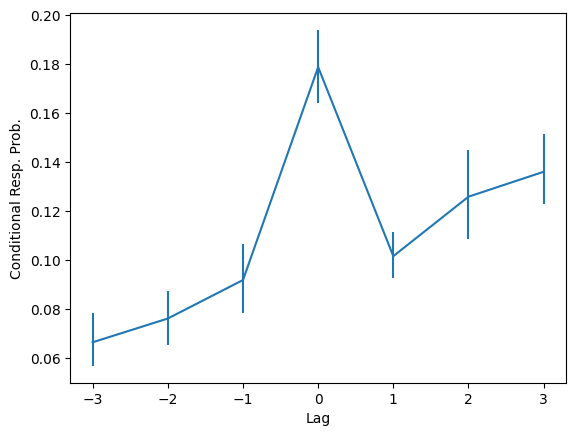

In [7]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

# plot
plot_rep_neighbor_crp([data], [trial_mask])
# jit(repneighborcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

In [8]:
# | exports

import numpy as np


def shuffle_matrix(matrix: np.ndarray, N: int) -> np.ndarray:
    """
    Shuffles rows of a matrix N times, stacking the results vertically.

    Parameters
    ----------
    matrix : np.ndarray
        2-D array to be shuffled.
    N : int
        Number of times to shuffle.

    Returns
    -------
    np.ndarray
        Vertically stacked shuffled matrices.
    """
    A, B = matrix.shape
    enlarged_matrix = np.tile(matrix, (N, 1))
    segmented_matrix = np.array_split(enlarged_matrix, N)
    for block in segmented_matrix:
        np.random.shuffle(block)
    return np.vstack(segmented_matrix)


def plot_rep_neighbor_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    control_trial_masks: Sequence[Bool[Array, " trial_count"]]
    | Bool[Array, " trial_count"],  # vectors to filter datasets by for control analysis
    max_lag: int = 3,
    control_experiment_count=100,
    ctrl_multiplier: int = 2,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted prob of lag-CRP for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum lag to plot.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)
    func = jit(repneighborcrp, static_argnames=("size"))

    for data_index, data in enumerate(datasets):
        lag_range = (jnp.max(data["listLength"]) - 1).item()

        trials = data["recalls"]
        presentations = data["pres_itemnos"]
        trial_mask = trial_masks[data_index]
        ctrl_trial_mask = control_trial_masks[data_index]
        subject_indices = data["subject"].flatten()
        main_subject_values = []
        control_subject_values = []

        for subject in jnp.unique(data["subject"]):
            subject_mask = jnp.logical_and(subject_indices == subject, trial_mask)
            if jnp.sum(subject_mask) == 0:
                continue
            main_subject_values.append(
                func(
                    trials[subject_mask],
                    presentations[subject_mask],
                    presentations[subject_mask],
                    size,
                )
            )

            ctrl_subject_mask = jnp.logical_and(
                subject_indices == subject, ctrl_trial_mask
            )
            shuffled_controls = jnp.array(
                shuffle_matrix(
                    np.array(trials)[ctrl_subject_mask],
                    control_experiment_count * ctrl_multiplier,
                )
            )
            repeated_presentations = jnp.array(
                np.tile(
                    np.array(presentations)[subject_mask],
                    (control_experiment_count, 1),
                )
            )
            # ctrl_repeated_presentations = np.tile(
            #     np.array(presentations)[ctrl_subject_mask],
            #     (control_experiment_count * ctrl_multiplier, 1),
            # )
            control_subject_values.append(
                func(
                    shuffled_controls,
                    # ctrl_repeated_presentations,
                    repeated_presentations,
                    repeated_presentations,
                    size,
                )
            )

        main_subject_values = np.vstack(main_subject_values)
        main_subject_values = main_subject_values[
            :, lag_range - max_lag : lag_range + max_lag + 1
        ]
        # main_subject_values[:, max_lag] = np.nan
        print(jnp.nanmean(main_subject_values, 0))

        color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            main_subject_values,
            "Mixed",
            color,
        )

        control_subject_values = np.vstack(control_subject_values)
        control_subject_values = control_subject_values[
            :, lag_range - max_lag : lag_range + max_lag + 1
        ]
        # control_subject_values[:, max_lag] = np.nan
        print(jnp.nanmean(control_subject_values, 0))
        control_color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            control_subject_values,
            "Control",
            control_color,
        )

    set_plot_labels(axis, "Lag", "Conditional Resp. Prob.", contrast_name)
    return axis

## Examples

### Data

[0.02190097 0.02396327 0.0322147  0.03714049 0.04907486 0.11758025
 0.04682104 0.06400595 0.05215135 0.06355532 0.07044693]
[0.02897349 0.03360992 0.03163881 0.03484788 0.03442088 0.14848322
 0.0428457  0.0503693  0.05465867 0.07441507 0.08748294]


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

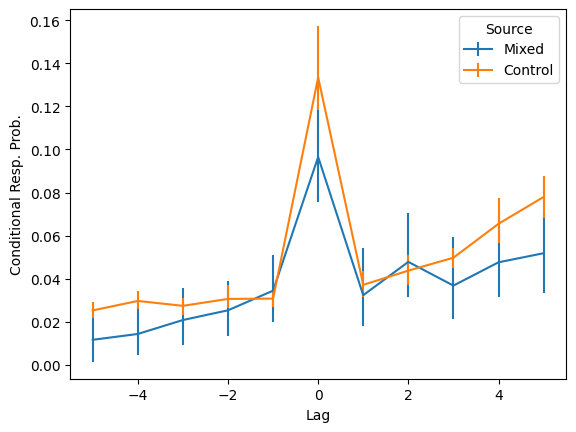

In [9]:
import os
import matplotlib.pyplot as plt
from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

# plot
plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    contrast_name="Source",
)
# jit(repneighborcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

[0.08589166 0.09390147 0.09369173 0.10750646 0.12638271 0.21432044
 0.13188964 0.16939574 0.1787771  0.1874576  0.19139743]
[0.09043556 0.09691717 0.11010555 0.12255862 0.1422308  0.21575122
 0.16264017 0.17824765 0.18148035 0.18342364 0.18718387]


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

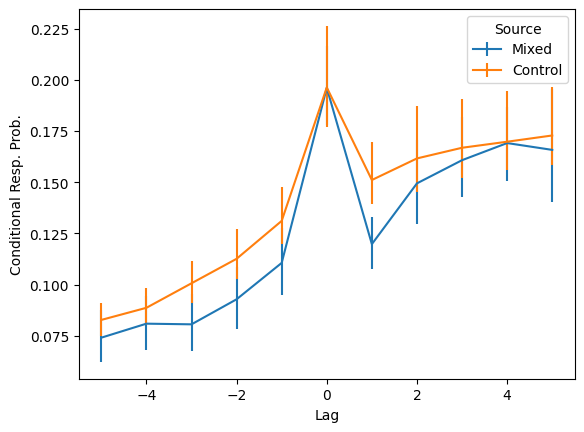

In [10]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

# plot
plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    contrast_name="Source",
)
# jit(repneighborcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

[0.06747326 0.07358842 0.07616683 0.08716588 0.10529581 0.19339983
 0.11066164 0.14300008 0.14932427 0.15822038 0.16436388]
[0.07324803 0.07906639 0.088549   0.0998379  0.11460917 0.20087785
 0.13209741 0.14699808 0.15070474 0.15922253 0.16311155]


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

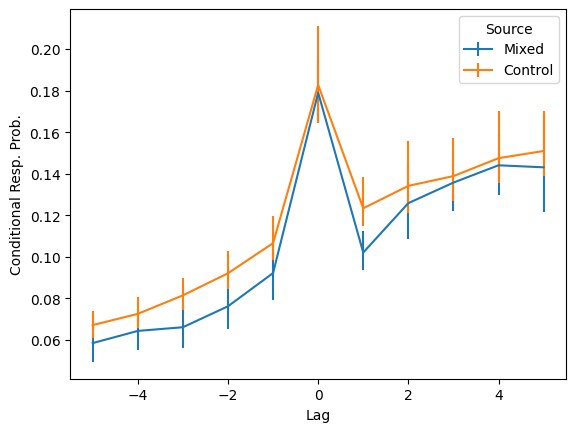

In [11]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

# plot
plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=2,
    contrast_name="Source",
)
# jit(repneighborcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

### Base CMR

[0.02984179 0.03418389 0.03408708 0.04050631 0.04804204 0.10193741
 0.06172031 0.05719778 0.05766759 0.06595512 0.06894368]
[0.02876195 0.03394775 0.03269277 0.035341   0.03744486 0.12350556
 0.04595111 0.04975676 0.05645056 0.06957219 0.07690988]


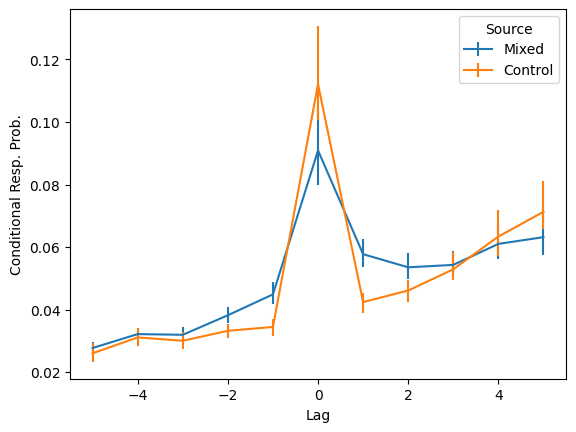

[0.09968869 0.10472181 0.11707976 0.12940456 0.1468762  0.20215891
 0.16584317 0.17248522 0.1752196  0.17554954 0.1736583 ]
[0.08797354 0.09322172 0.10219274 0.11500814 0.13200225 0.18426353
 0.14230795 0.15970464 0.16096155 0.16140193 0.16797744]


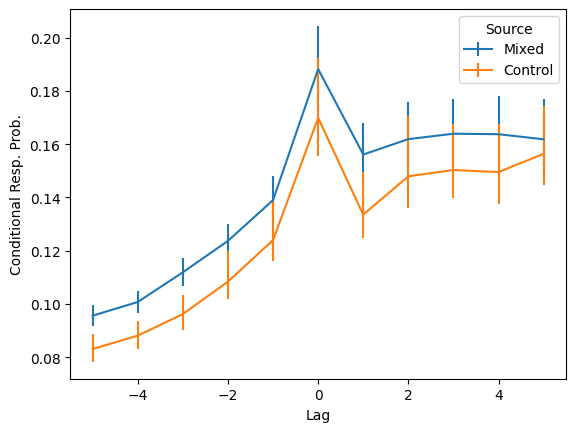

[0.08054612 0.08539045 0.09485935 0.10674776 0.12238438 0.18087624
 0.14012456 0.14500847 0.14813833 0.15040073 0.14989781]
[0.07229117 0.07688044 0.08436256 0.09291843 0.10759148 0.17386954
 0.11773787 0.13312866 0.13718905 0.14273173 0.14815944]


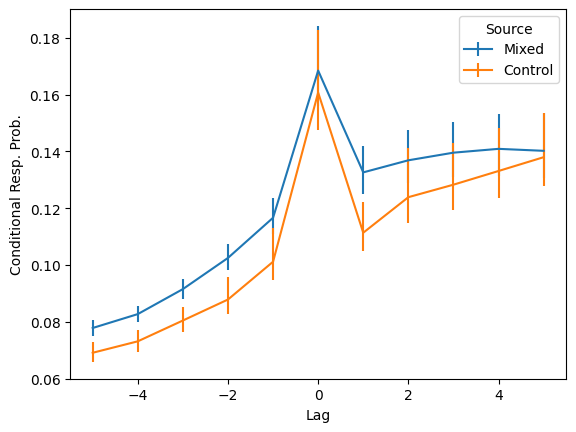

In [ ]:
# | notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_cmr import BaseCMRFactory as weird_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)


# | notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: jnp.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

# plot_neighbor_contiguity(
#     [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
#     control_experiment_count=1)
# plt.show()

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()


# | notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=2,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

### No-Reinstate CMR

[0.02984179 0.03418389 0.03408708 0.04050631 0.04804204 0.10193741
 0.06172031 0.05719778 0.05766759 0.06595512 0.06894368]
[0.02881027 0.03168261 0.03361043 0.03670877 0.03999437 0.12942725
 0.04438812 0.05002169 0.05328153 0.06951358 0.07602997]


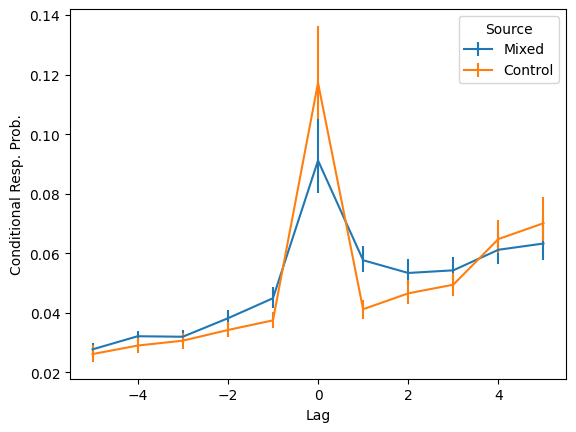

[0.09968869 0.10472181 0.11707976 0.12940456 0.1468762  0.20215891
 0.16584317 0.17248522 0.1752196  0.17554954 0.1736583 ]
[0.08773411 0.09353672 0.10328747 0.1163777  0.12960863 0.18608916
 0.1439018  0.16009095 0.16019739 0.16478778 0.16693823]


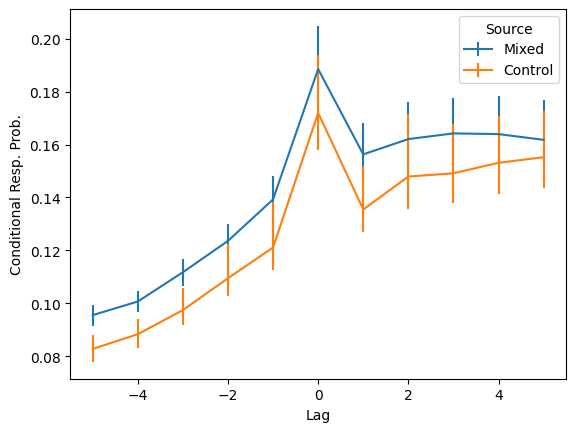

[0.08054612 0.08539045 0.09485935 0.10674776 0.12238438 0.18087624
 0.14012456 0.14500847 0.14813833 0.15040073 0.14989781]
[0.07176897 0.07716519 0.08443947 0.09476884 0.10837382 0.17045382
 0.11921237 0.13444299 0.1358551  0.14069863 0.14669235]


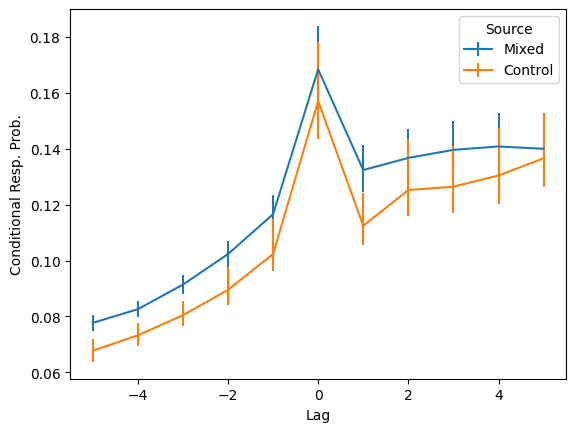

In [ ]:
# | notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_cmr import BaseCMRFactory as weird_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

# | notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: jnp.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=2,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

### Positional CMR

[0.02875512 0.0288066  0.03180114 0.03280378 0.03809325 0.11351689
 0.0437181  0.0514616  0.05633759 0.07068217 0.07628382]
[0.02680176 0.02985732 0.0295049  0.0359205  0.04015395 0.1336554
 0.04482171 0.05242316 0.05755284 0.07542932 0.08282415]


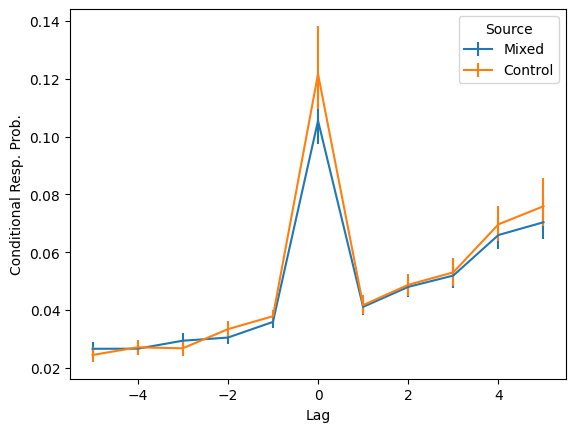

[0.09457903 0.0983361  0.1048398  0.11915991 0.13222323 0.20227501
 0.14397262 0.16414864 0.17186385 0.1761522  0.17249449]
[0.08648152 0.09040842 0.1008569  0.11726097 0.13685812 0.20351826
 0.15130946 0.17252697 0.17571405 0.17935999 0.18471868]


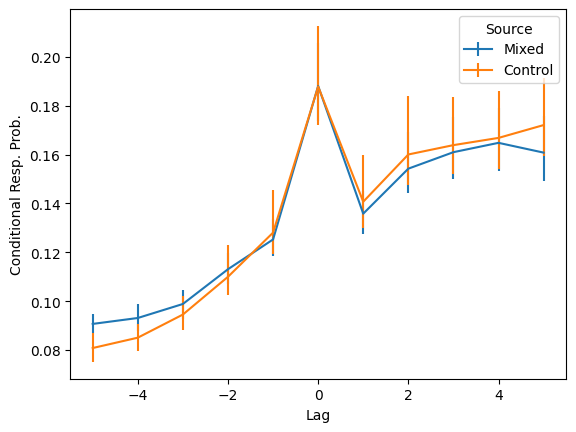

[0.07649754 0.07934429 0.08521407 0.09716345 0.10908364 0.18462192
 0.11949778 0.1379324  0.14615196 0.15304191 0.15167864]
[0.06825154 0.07520688 0.08196417 0.09603194 0.11196308 0.19029236
 0.12678151 0.14411792 0.14868447 0.1573015  0.16213627]


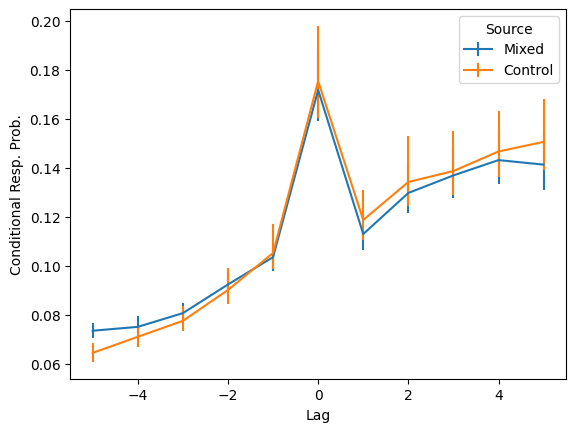

In [ ]:
# | notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_position_scale_cmr import (
    BaseCMRFactory as weird_position_scale_cmr_model_factory,
)

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdPositionScaleCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_position_scale_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

# | notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: jnp.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()
# | notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=2,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

### CMR-DE

[0.02863843 0.02928986 0.03310217 0.03490211 0.04263689 0.09474321
 0.049437   0.05138275 0.05251604 0.06609741 0.07087354]
[0.02926843 0.03047548 0.03265215 0.03647503 0.03823715 0.12657681
 0.04484011 0.04920501 0.05551744 0.06686836 0.07975947]


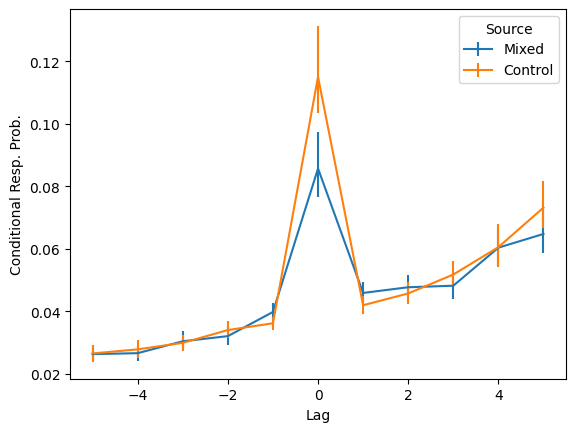

[0.09265833 0.09713515 0.10886032 0.12552485 0.14049982 0.22254905
 0.16130611 0.17847729 0.1837583  0.19169706 0.18961878]
[0.08646502 0.09099417 0.09917691 0.11227955 0.12798971 0.18455982
 0.14142887 0.15886007 0.16191475 0.16443595 0.16823542]


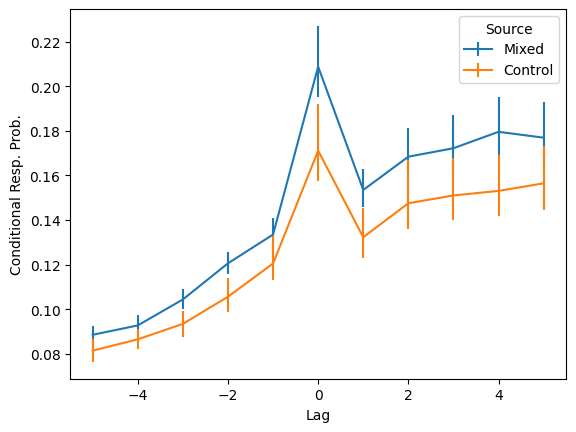

[0.0751446  0.07859301 0.08862574 0.10252818 0.11625859 0.19581752
 0.13388468 0.14864951 0.1541643  0.16374792 0.16347742]
[0.07096739 0.07550117 0.08258148 0.0916852  0.10575536 0.1750285
 0.11782401 0.13411997 0.1371867  0.14307739 0.14943916]


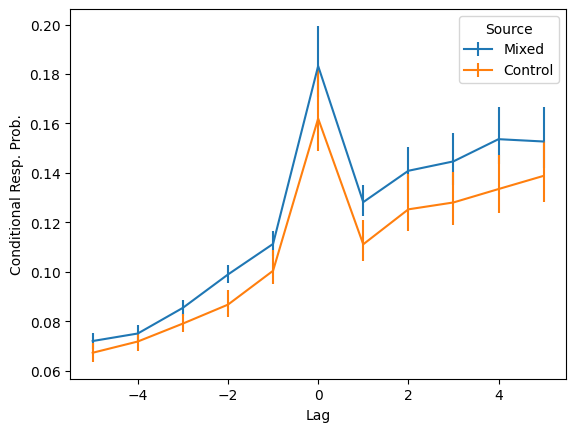

In [ ]:
# | notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.outlistcmrde import BaseCMRFactory as outlistcmrde_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_OutlistCMRDE_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=outlistcmrde_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

# | notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: jnp.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=1,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()

# | notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_rep_neighbor_crp(
    [data],
    [trial_mask],
    [control_trial_mask],
    max_lag=5,
    size=3,
    ctrl_multiplier=2,
    control_experiment_count=1,
    contrast_name="Source",
)
plt.show()